In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 3
price = 200
iteration = 5


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Warehouse New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    40,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

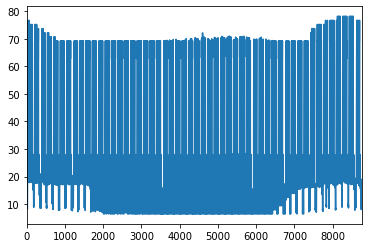

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 10,626.92
78.13965517958043


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 4,598 m²
Roof area is up 70 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.425081491470337 sec


0.0


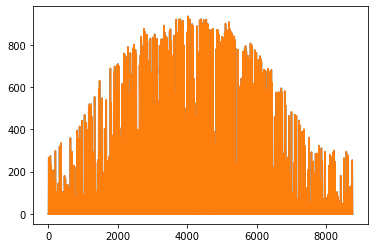

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


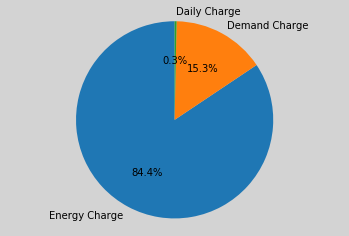

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

261136.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    4667.576
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         20723.9
Aug         22065.5
Dec         23271.5
Feb         20983.8
Jan         23774.3
Jul         19933.9
Jun         20611.8
Mar         23584.0
May         21175.7
Nov         22611.0
Oct         21919.2
Sep         20481.3
monthly_import    261135.9
dtype: float64
261136.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 115, 110, 46, 11, 51, 0.7999999999999998, 0.8999999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 23.2538, 0.0]


ERROR:ga_logger:Cost: 30499.4


ERROR:ga_logger:total demand cost: 4634.783


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 256,915 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,499 per year


Total roof area of the  building: 4,598 m²
Total roof area used 26 m²
Percentage: 0.6%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 210, 180, 11, 21, 41, 0.7999999999999998, 0.44999999999999996, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 104s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29314.2


ERROR:ga_logger:total demand cost: 4483.912


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,784 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,314 per year


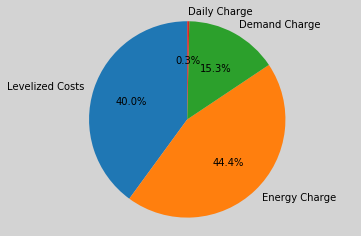

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 175, 225, 11, 41, 36, 0.44999999999999996, 0.8999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29900.2


ERROR:ga_logger:total demand cost: 4452.689


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,894 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 29,900 per year


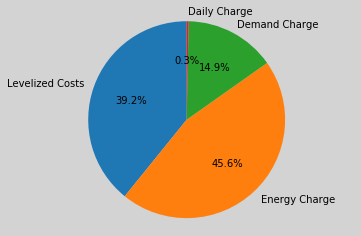

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 155, 220, 21, 31, 11, 0.7, 0.44999999999999996, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29283.6


ERROR:ga_logger:total demand cost: 4469.484


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,113 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,284 per year


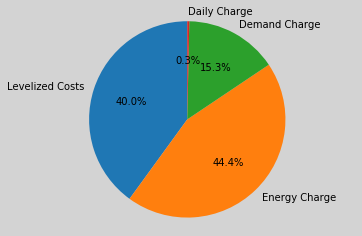

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 265, 190, 36, 31, 51, 0.5999999999999999, 0.44999999999999996, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29708.1


ERROR:ga_logger:total demand cost: 4481.446


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,559 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 29,708 per year


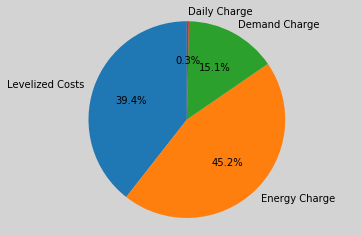

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 255, 130, 6, 51, 21, 0.5499999999999999, 0.5999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.804889678955078 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29833.9


ERROR:ga_logger:total demand cost: 4459.391


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,482 kWh
At a cost of $ 0.0786 /kWh
Total Cost of the system: $ 29,834 per year


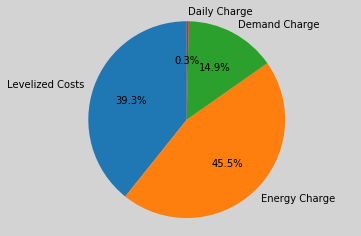

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 220, 175, 46, 16, 51, 0.25, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29557.2


ERROR:ga_logger:total demand cost: 4480.233


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,257 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 29,557 per year


Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 140, 140, 26, 41, 41, 0.49999999999999994, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.971668481826782 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.902684926986694 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29180.1


ERROR:ga_logger:total demand cost: 4465.512000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,161 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,180 per year


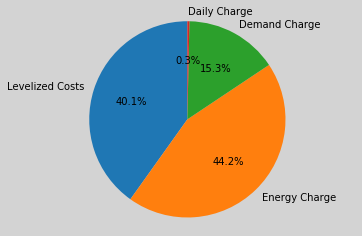

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 120, 150, 41, 36, 6, 0.35, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 41.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.968981742858887 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30208.9


ERROR:ga_logger:total demand cost: 4451.733


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,343 kWh
At a cost of $ 0.0795 /kWh
Total Cost of the system: $ 30,209 per year


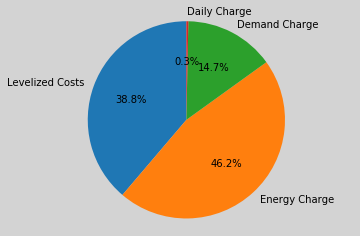

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 225, 170, 41, 51, 21, 0.3, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29810.1


ERROR:ga_logger:total demand cost: 4469.93


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,467 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 29,810 per year


Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 200, 200, 36, 16, 31, 0.49999999999999994, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.400575876235962 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29620.8


ERROR:ga_logger:total demand cost: 4457.722


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,825 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 29,621 per year


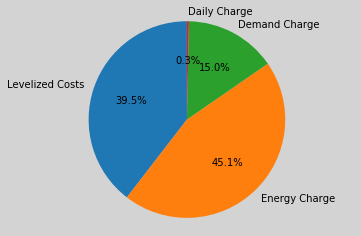

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 205, 155, 16, 26, 16, 0.6499999999999999, 0.25, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.035895109176636 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29228.3


ERROR:ga_logger:total demand cost: 4460.511


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,652 kWh
At a cost of $ 0.0742 /kWh
Total Cost of the system: $ 29,228 per year


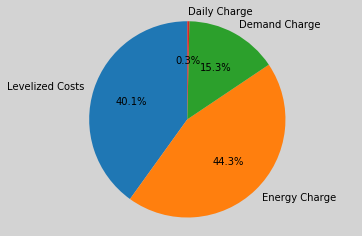

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 230, 210, 51, 41, 16, 0.35, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29671.1


ERROR:ga_logger:total demand cost: 4455.685


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,825 kWh
At a cost of $ 0.0762 /kWh
Total Cost of the system: $ 29,671 per year


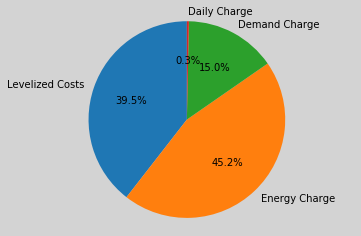

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 215, 215, 36, 36, 56, 0.49999999999999994, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.226656675338745 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29862.8


ERROR:ga_logger:total demand cost: 4477.1759999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,377 kWh
At a cost of $ 0.0783 /kWh
Total Cost of the system: $ 29,863 per year


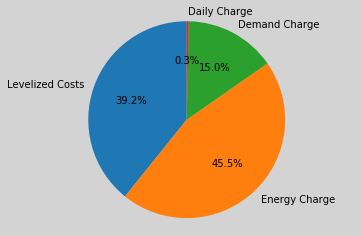

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 165, 170, 31, 46, 16, 0.7499999999999998, 0.49999999999999994, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.581959247589111 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29647.5


ERROR:ga_logger:total demand cost: 4490.624


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,887 kWh
At a cost of $ 0.0768 /kWh
Total Cost of the system: $ 29,648 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 245, 190, 26, 16, 31, 0.7499999999999998, 0.8999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29818.9


ERROR:ga_logger:total demand cost: 4474.574


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,959 kWh
At a cost of $ 0.0774 /kWh
Total Cost of the system: $ 29,819 per year


Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 265, 265, 26, 21, 56, 0.49999999999999994, 0.7999999999999998, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.676461219787598 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30390.9


ERROR:ga_logger:total demand cost: 4465.667


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 182,972 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 30,391 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 190, 95, 41, 31, 36, 0.6499999999999999, 0.5999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29326.1


ERROR:ga_logger:total demand cost: 4474.871


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,035 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,326 per year


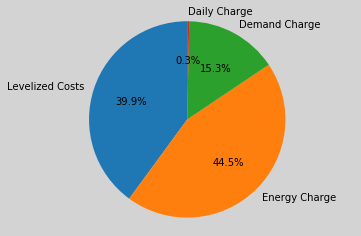

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 195, 155, 46, 41, 21, 0.49999999999999994, 0.5499999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29263.2


ERROR:ga_logger:total demand cost: 4457.318


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 231,044 kWh
At a cost of $ 0.0562 /kWh
Total Cost of the system: $ 29,263 per year


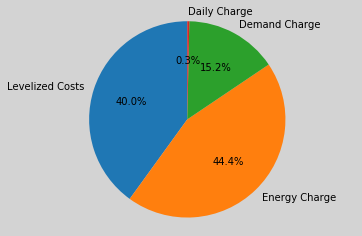

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 170, 190, 6, 51, 16, 0.8499999999999999, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29391.9


ERROR:ga_logger:total demand cost: 4486.422


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,477 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 29,392 per year


ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 175, 230, 41, 56, 36, 0.8499999999999999, 0.39999999999999997, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29938.8


ERROR:ga_logger:total demand cost: 4499.6849999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,216 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 29,939 per year


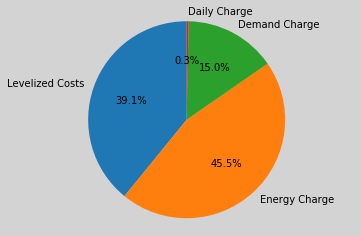

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 235, 155, 46, 1, 51, 0.8999999999999999, 0.7999999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.1512451171875 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30458.0


ERROR:ga_logger:total demand cost: 4502.634


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,398 kWh
At a cost of $ 0.0797 /kWh
Total Cost of the system: $ 30,458 per year


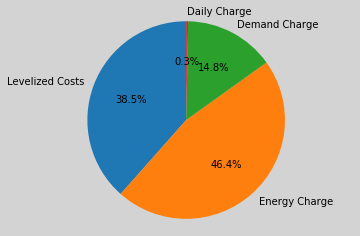

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 235, 155, 6, 21, 16, 0.35, 0.8499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29449.7


ERROR:ga_logger:total demand cost: 4453.57


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,384 kWh
At a cost of $ 0.0769 /kWh
Total Cost of the system: $ 29,450 per year


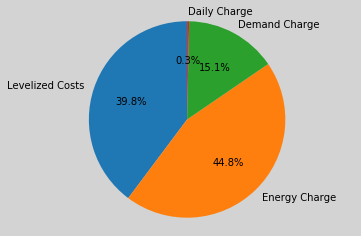

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 235, 150, 31, 1, 26, 0.39999999999999997, 0.2, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.026556730270386 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29260.7


ERROR:ga_logger:total demand cost: 4462.004999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,317 kWh
At a cost of $ 0.0763 /kWh
Total Cost of the system: $ 29,261 per year


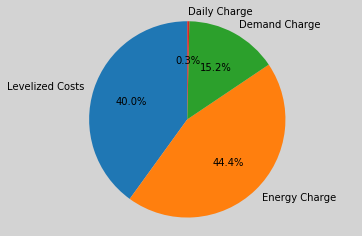

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (105, 210, 115, 16, 26, 6, 0.7999999999999998, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 16.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.030098915100098 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30207.5


ERROR:ga_logger:total demand cost: 4477.247


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,886 kWh
At a cost of $ 0.0778 /kWh
Total Cost of the system: $ 30,208 per year


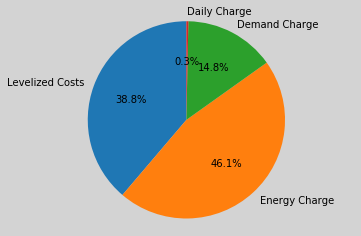

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 260, 95, 51, 41, 36, 0.8999999999999999, 0.5999999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


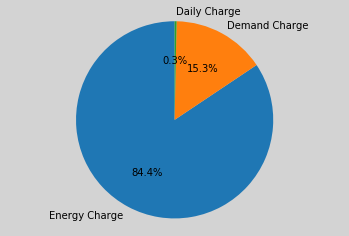

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 150, 250, 16, 1, 41, 0.39999999999999997, 0.2, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29417.4


ERROR:ga_logger:total demand cost: 4455.09


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,231 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 29,417 per year


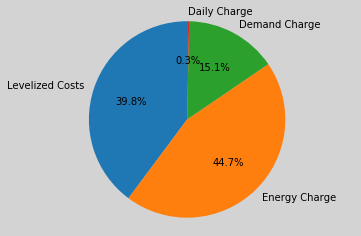

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 105, 125, 21, 31, 11, 0.7999999999999998, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30121.5


ERROR:ga_logger:total demand cost: 4452.8589999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,864 kWh
At a cost of $ 0.0797 /kWh
Total Cost of the system: $ 30,122 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 175, 120, 6, 46, 6, 0.5999999999999999, 0.8999999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30252.0


ERROR:ga_logger:total demand cost: 4451.017000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,309 kWh
At a cost of $ 0.0798 /kWh
Total Cost of the system: $ 30,252 per year


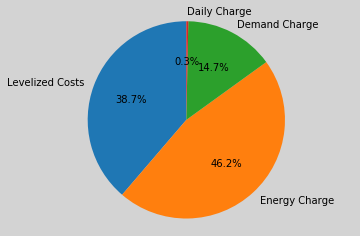

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 170, 130, 46, 11, 16, 0.5499999999999999, 0.2, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29694.1


ERROR:ga_logger:total demand cost: 4451.617


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,297 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 29,694 per year


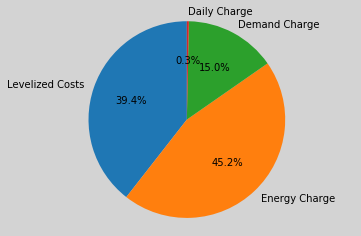

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (195, 90, 255, 16, 11, 11, 0.5499999999999999, 0.8499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.460779190063477 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29534.8


ERROR:ga_logger:total demand cost: 4456.906999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,267 kWh
At a cost of $ 0.0761 /kWh
Total Cost of the system: $ 29,535 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 160, 175, 56, 6, 6, 0.8499999999999999, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30115.9


ERROR:ga_logger:total demand cost: 4450.537


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,152 kWh
At a cost of $ 0.0791 /kWh
Total Cost of the system: $ 30,116 per year


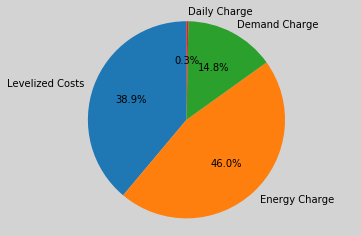

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (105, 220, 205, 31, 46, 26, 0.5499999999999999, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29775.8


ERROR:ga_logger:total demand cost: 4472.398


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,918 kWh
At a cost of $ 0.0763 /kWh
Total Cost of the system: $ 29,776 per year


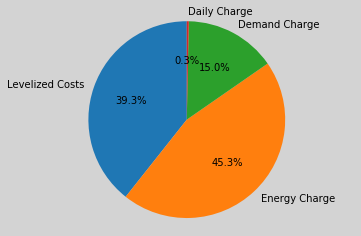

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 185, 230, 51, 51, 56, 0.6499999999999999, 0.49999999999999994, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29732.8


ERROR:ga_logger:total demand cost: 4497.715


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,708 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 29,733 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 180, 165, 41, 36, 36, 0.8999999999999999, 0.35, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 28987.2


ERROR:ga_logger:total demand cost: 4472.204


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,771 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 28,987 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 105, 180, 6, 51, 26, 0.35, 0.5999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29101.8


ERROR:ga_logger:total demand cost: 4464.223


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,126 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,102 per year


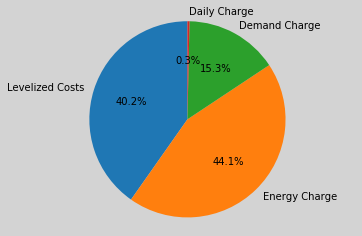

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 205, 215, 36, 41, 31, 0.49999999999999994, 0.8499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29184.2


ERROR:ga_logger:total demand cost: 4477.356


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,107 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,184 per year


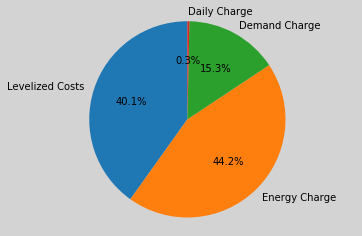

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 195, 235, 51, 26, 1, 0.39999999999999997, 0.5999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29376.1


ERROR:ga_logger:total demand cost: 4468.53


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,503 kWh
At a cost of $ 0.0751 /kWh
Total Cost of the system: $ 29,376 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 160, 120, 11, 21, 21, 0.7499999999999998, 0.35, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.9066197872161865 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29238.3


ERROR:ga_logger:total demand cost: 4457.959000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,766 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,238 per year


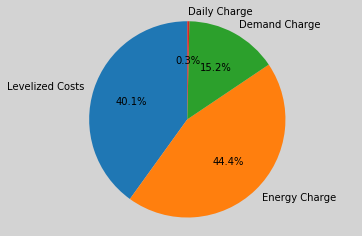

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 220, 115, 26, 6, 41, 0.5499999999999999, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30020.2


ERROR:ga_logger:total demand cost: 4466.726000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,439 kWh
At a cost of $ 0.0792 /kWh
Total Cost of the system: $ 30,020 per year


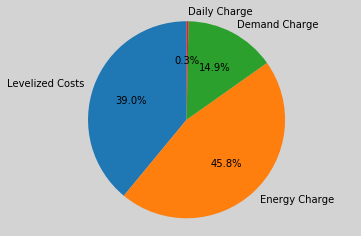

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 125, 170, 16, 41, 41, 0.6499999999999999, 0.5499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30404.4


ERROR:ga_logger:total demand cost: 4502.245


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,338 kWh
At a cost of $ 0.0786 /kWh
Total Cost of the system: $ 30,404 per year


Total roof area of the  building: 4,598 m²
Total roof area used 735 m²
Percentage: 16.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 185, 255, 36, 41, 6, 0.35, 0.35, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29063.5


ERROR:ga_logger:total demand cost: 4478.042


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,744 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 29,064 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 95, 95, 21, 16, 51, 0.49999999999999994, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.636475563049316 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [28.0739, 0.0, 0.0]


ERROR:ga_logger:Cost: 30492.8


ERROR:ga_logger:total demand cost: 4626.339


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 256,026 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,493 per year


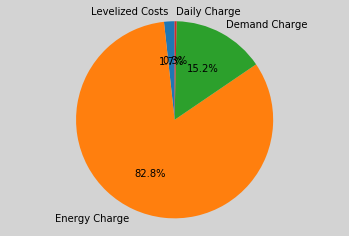

Total roof area of the  building: 4,598 m²
Total roof area used 56 m²
Percentage: 1.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 180, 160, 41, 51, 1, 0.44999999999999996, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.558811902999878 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29506.1


ERROR:ga_logger:total demand cost: 4481.674


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,118 kWh
At a cost of $ 0.0768 /kWh
Total Cost of the system: $ 29,506 per year


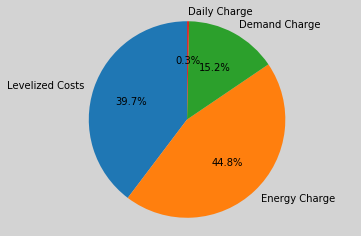

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 260, 190, 51, 31, 1, 0.5999999999999999, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 34.6449]


ERROR:ga_logger:Cost: 30484.3


ERROR:ga_logger:total demand cost: 4623.262


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 254,725 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,484 per year


Total roof area of the  building: 4,598 m²
Total roof area used 87 m²
Percentage: 1.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 170, 165, 56, 26, 41, 0.8499999999999999, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.096309423446655 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.796923637390137 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29330.5


ERROR:ga_logger:total demand cost: 4468.441


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,594 kWh
At a cost of $ 0.0756 /kWh
Total Cost of the system: $ 29,330 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 225, 180, 31, 6, 26, 0.5999999999999999, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 6.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.770505666732788 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.244473934173584 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29353.5


ERROR:ga_logger:total demand cost: 4474.787


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,038 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 29,354 per year


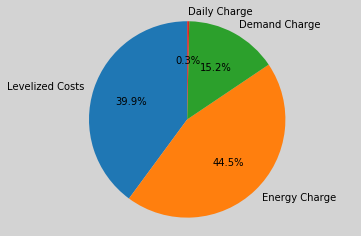

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 95, 195, 31, 46, 26, 0.2, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28885.3


ERROR:ga_logger:total demand cost: 4463.697


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,550 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 28,885 per year


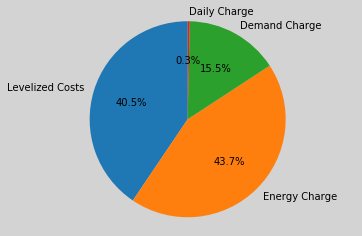

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 210, 200, 1, 51, 41, 0.2, 0.2, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.681713104248047 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.61808443069458 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29781.2


ERROR:ga_logger:total demand cost: 4484.724


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,165 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,781 per year


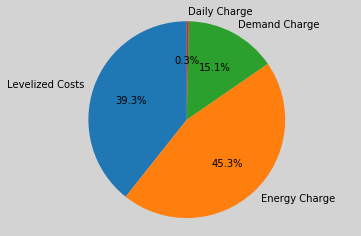

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 210, 120, 6, 31, 36, 0.39999999999999997, 0.8499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30120.7


ERROR:ga_logger:total demand cost: 4450.639


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,724 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 30,121 per year


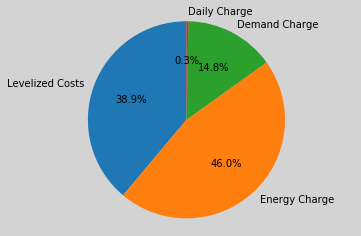

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 265, 120, 11, 56, 21, 0.39999999999999997, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [66.7669, 0.0, 0.0]


ERROR:ga_logger:Cost: 30478.7


ERROR:ga_logger:total demand cost: 4613.115


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 248,814 kWh
At a cost of $ 0.0985 /kWh
Total Cost of the system: $ 30,479 per year


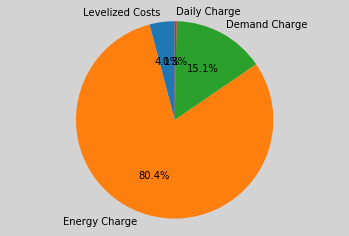

Total roof area of the  building: 4,598 m²
Total roof area used 167 m²
Percentage: 3.6%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 135, 185, 1, 56, 11, 0.39999999999999997, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.169778347015381 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29776.4


ERROR:ga_logger:total demand cost: 4454.244


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,441 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 29,776 per year


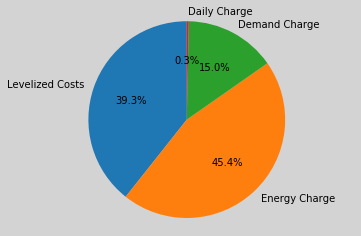

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 115, 245, 26, 26, 11, 0.6499999999999999, 0.7999999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29654.7


ERROR:ga_logger:total demand cost: 4470.367


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,531 kWh
At a cost of $ 0.0758 /kWh
Total Cost of the system: $ 29,655 per year


Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (200, 265, 90, 46, 31, 36, 0.8499999999999999, 0.49999999999999994, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [19.0475, 0.0, 0.0]


ERROR:ga_logger:Cost: 30498.8


ERROR:ga_logger:total demand cost: 4638.3640000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 257,683 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,499 per year


Total roof area of the  building: 4,598 m²
Total roof area used 22 m²
Percentage: 0.5%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 175, 265, 46, 36, 1, 0.35, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.090318441390991 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 28935.2


ERROR:ga_logger:total demand cost: 4470.735


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,855 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 28,935 per year


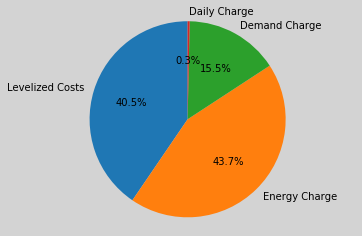

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 150, 115, 31, 6, 36, 0.5499999999999999, 0.6499999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30178.3


ERROR:ga_logger:total demand cost: 4451.201


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,093 kWh
At a cost of $ 0.0795 /kWh
Total Cost of the system: $ 30,178 per year


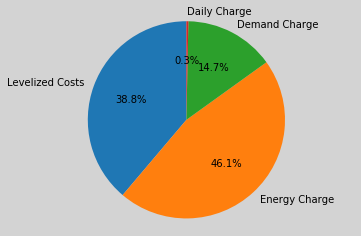

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (195, 260, 205, 21, 1, 1, 0.35, 0.2, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29255.5


ERROR:ga_logger:total demand cost: 4458.068


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,055 kWh
At a cost of $ 0.0746 /kWh
Total Cost of the system: $ 29,256 per year


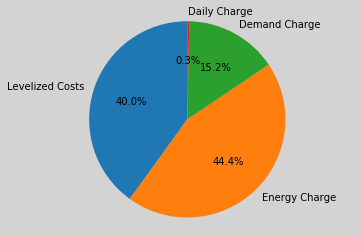

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 185, 130, 26, 51, 41, 0.3, 0.7, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30045.5


ERROR:ga_logger:total demand cost: 4477.775


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,987 kWh
At a cost of $ 0.0791 /kWh
Total Cost of the system: $ 30,046 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 115, 185, 36, 1, 51, 0.44999999999999996, 0.25, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29147.4


ERROR:ga_logger:total demand cost: 4475.444


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,662 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,147 per year


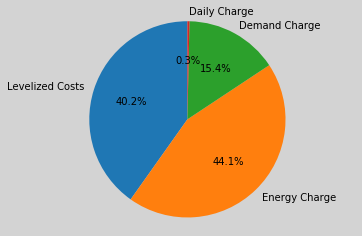

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 185, 160, 1, 21, 51, 0.8999999999999999, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.442279577255249 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.967560052871704 sec


ERROR:ga_logger:Generated the panel irradiance in  16s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29400.0


ERROR:ga_logger:total demand cost: 4464.106000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,285 kWh
At a cost of $ 0.0757 /kWh
Total Cost of the system: $ 29,400 per year


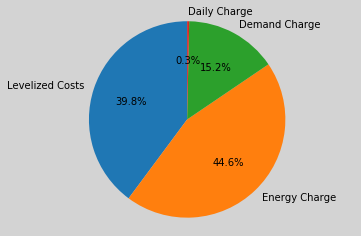

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 120, 215, 41, 21, 21, 0.7499999999999998, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29654.2


ERROR:ga_logger:total demand cost: 4460.532


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,780 kWh
At a cost of $ 0.0757 /kWh
Total Cost of the system: $ 29,654 per year


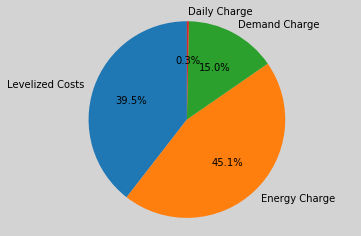

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 200, 95, 6, 11, 26, 0.35, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.252569198608398 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29791.4


ERROR:ga_logger:total demand cost: 4451.84


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,982 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 29,791 per year


Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 95, 205, 56, 21, 16, 0.8999999999999999, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29729.4


ERROR:ga_logger:total demand cost: 4458.697999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,601 kWh
At a cost of $ 0.0767 /kWh
Total Cost of the system: $ 29,729 per year


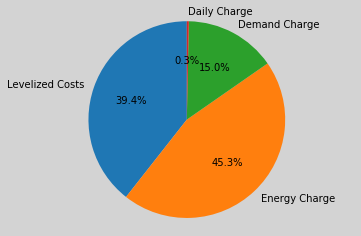

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 190, 130, 1, 16, 46, 0.7999999999999998, 0.8499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.945414781570435 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29952.1


ERROR:ga_logger:total demand cost: 4465.24


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,622 kWh
At a cost of $ 0.0779 /kWh
Total Cost of the system: $ 29,952 per year


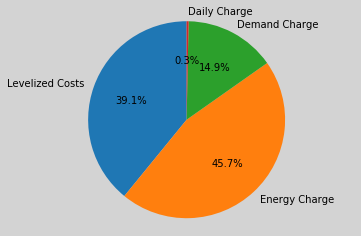

Total roof area of the  building: 4,598 m²
Total roof area used 735 m²
Percentage: 16.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 160, 235, 46, 6, 11, 0.25, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29156.0


ERROR:ga_logger:total demand cost: 4480.37


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,073 kWh
At a cost of $ 0.0752 /kWh
Total Cost of the system: $ 29,156 per year


Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 225, 145, 31, 36, 6, 0.8499999999999999, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30026.8


ERROR:ga_logger:total demand cost: 4475.703


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 181,801 kWh
At a cost of $ 0.0756 /kWh
Total Cost of the system: $ 30,027 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 115, 150, 26, 6, 51, 0.8999999999999999, 0.49999999999999994, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.177809000015259 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30204.4


ERROR:ga_logger:total demand cost: 4483.091


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,951 kWh
At a cost of $ 0.0782 /kWh
Total Cost of the system: $ 30,204 per year


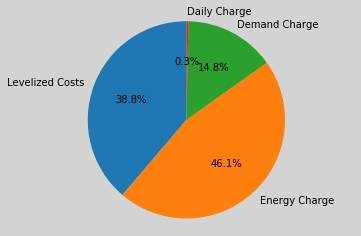

Total roof area of the  building: 4,598 m²
Total roof area used 694 m²
Percentage: 15.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 195, 190, 6, 36, 16, 0.5499999999999999, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.659334421157837 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.791959762573242 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29415.5


ERROR:ga_logger:total demand cost: 4453.977


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,229 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 29,416 per year


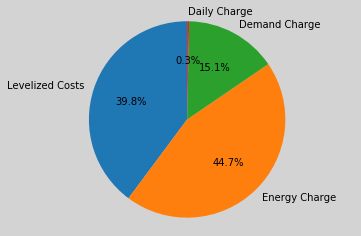

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 115, 130, 31, 36, 36, 0.44999999999999996, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.136265754699707 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 36.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.723915100097656 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 15.269842624664307 sec


ERROR:ga_logger:Generated the panel irradiance in  28s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30069.6


ERROR:ga_logger:total demand cost: 4469.789000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 181,668 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 30,070 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 200, 175, 31, 6, 41, 0.7499999999999998, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.758492469787598 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29161.4


ERROR:ga_logger:total demand cost: 4479.816


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,222 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,161 per year


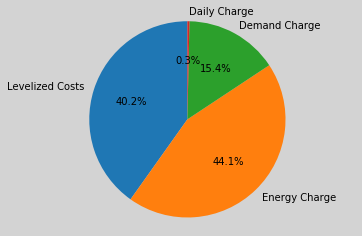

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 130, 175, 36, 21, 41, 0.5499999999999999, 0.6499999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.2886834144592285 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29824.8


ERROR:ga_logger:total demand cost: 4493.709000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,504 kWh
At a cost of $ 0.0766 /kWh
Total Cost of the system: $ 29,825 per year


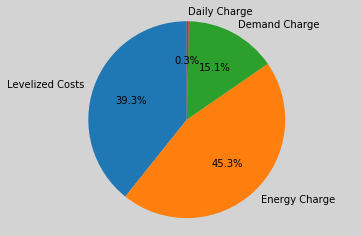

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 145, 210, 56, 46, 56, 0.8999999999999999, 0.5999999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.798054456710815 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 2.64391, 622.356]


ERROR:ga_logger:Cost: 30328.6


ERROR:ga_logger:total demand cost: 4497.561


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 183,182 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 30,329 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,783 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 255, 265, 11, 31, 6, 0.35, 0.49999999999999994, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.145205974578857 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30233.7


ERROR:ga_logger:total demand cost: 4452.0869999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,364 kWh
At a cost of $ 0.0801 /kWh
Total Cost of the system: $ 30,234 per year


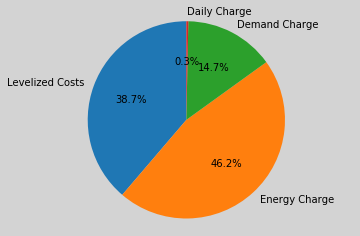

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 110, 190, 31, 46, 21, 0.39999999999999997, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.004781007766724 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29249.8


ERROR:ga_logger:total demand cost: 4459.549999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,969 kWh
At a cost of $ 0.0750 /kWh
Total Cost of the system: $ 29,250 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 190, 240, 26, 31, 56, 0.5999999999999999, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.217148065567017 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29229.8


ERROR:ga_logger:total demand cost: 4472.949


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,655 kWh
At a cost of $ 0.0746 /kWh
Total Cost of the system: $ 29,230 per year


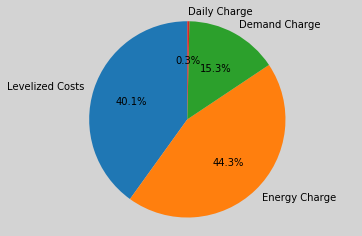

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 235, 240, 21, 16, 1, 0.49999999999999994, 0.8999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.937725782394409 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.610994338989258 sec


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29409.1


ERROR:ga_logger:total demand cost: 4460.357


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,083 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 29,409 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 160, 250, 36, 21, 36, 0.5999999999999999, 0.7499999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29778.2


ERROR:ga_logger:total demand cost: 4467.637000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,390 kWh
At a cost of $ 0.0774 /kWh
Total Cost of the system: $ 29,778 per year


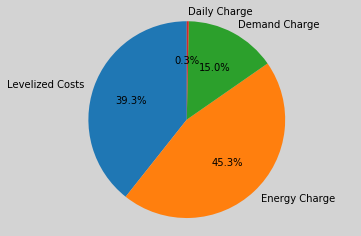

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 135, 155, 21, 6, 56, 0.5999999999999999, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29986.2


ERROR:ga_logger:total demand cost: 4494.871000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,622 kWh
At a cost of $ 0.0788 /kWh
Total Cost of the system: $ 29,986 per year


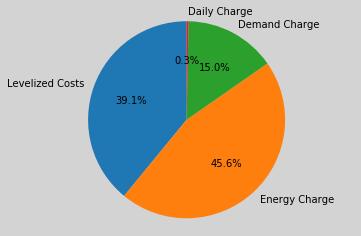

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 235, 125, 6, 21, 16, 0.8499999999999999, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 16.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.982652187347412 sec


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30037.1


ERROR:ga_logger:total demand cost: 4457.546


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,999 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 30,037 per year


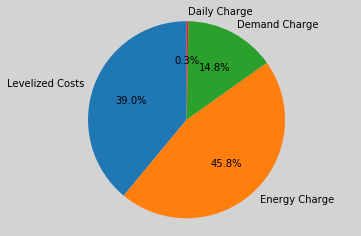

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 185, 160, 6, 16, 31, 0.3, 0.39999999999999997, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29413.9


ERROR:ga_logger:total demand cost: 4455.128000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,082 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,414 per year


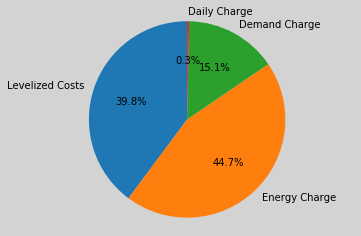

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 150, 165, 41, 46, 26, 0.5999999999999999, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.857861518859863 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.16749119758606 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29160.2


ERROR:ga_logger:total demand cost: 4464.168


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,118 kWh
At a cost of $ 0.0753 /kWh
Total Cost of the system: $ 29,160 per year


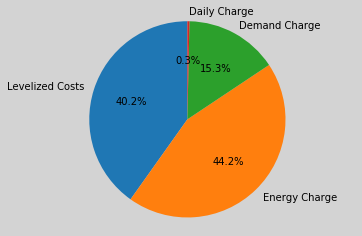

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 255, 220, 41, 16, 21, 0.8999999999999999, 0.7999999999999998, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29657.7


ERROR:ga_logger:total demand cost: 4457.513000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,374 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 29,658 per year


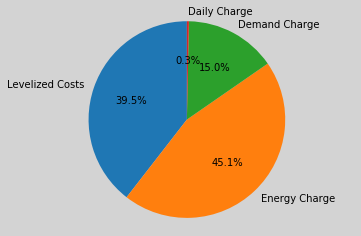

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (225, 130, 140, 31, 36, 6, 0.6499999999999999, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.308594465255737 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30243.4


ERROR:ga_logger:total demand cost: 4451.420999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 182,093 kWh
At a cost of $ 0.0768 /kWh
Total Cost of the system: $ 30,243 per year


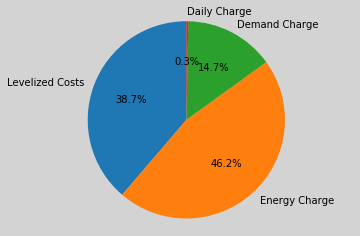

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 125, 125, 1, 21, 41, 0.8999999999999999, 0.7999999999999998, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.494343280792236 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29966.7


ERROR:ga_logger:total demand cost: 4472.974


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,458 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 29,967 per year


Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 90, 110, 6, 36, 36, 0.8999999999999999, 0.5999999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30335.0


ERROR:ga_logger:total demand cost: 4453.952


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,355 kWh
At a cost of $ 0.0798 /kWh
Total Cost of the system: $ 30,335 per year


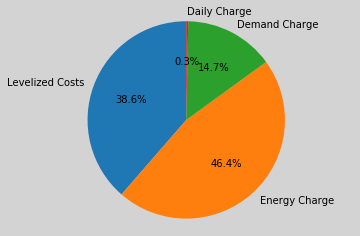

Total roof area of the  building: 4,598 m²
Total roof area used 694 m²
Percentage: 15.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 200, 230, 6, 21, 41, 0.8499999999999999, 0.35, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.835132598876953 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.871275901794434 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29316.0


ERROR:ga_logger:total demand cost: 4458.083


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,184 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,316 per year


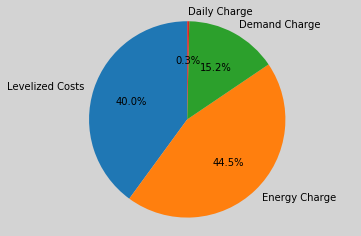

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 190, 90, 16, 1, 21, 0.25, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.592390537261963 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   5s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30120.4


ERROR:ga_logger:total demand cost: 4453.826000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,319 kWh
At a cost of $ 0.0799 /kWh
Total Cost of the system: $ 30,120 per year


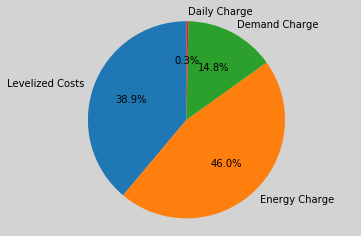

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 180, 210, 21, 56, 6, 0.44999999999999996, 0.39999999999999997, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29925.2


ERROR:ga_logger:total demand cost: 4499.72


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,055 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 29,925 per year


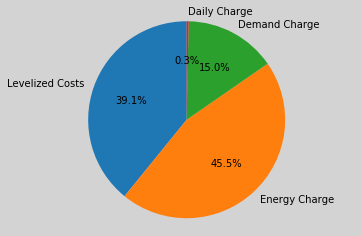

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 170, 160, 31, 1, 31, 0.49999999999999994, 0.7999999999999998, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.322005987167358 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.6188530921936035 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29106.9


ERROR:ga_logger:total demand cost: 4471.19


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,846 kWh
At a cost of $ 0.0742 /kWh
Total Cost of the system: $ 29,107 per year


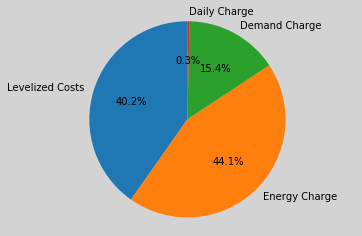

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 175, 265, 41, 6, 56, 0.2, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.743806600570679 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30108.6


ERROR:ga_logger:total demand cost: 4450.91


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,485 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 30,109 per year


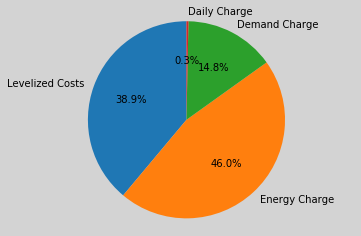

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 135, 195, 1, 16, 1, 0.39999999999999997, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6414573192596436 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 4.281996965408325 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29730.7


ERROR:ga_logger:total demand cost: 4454.1990000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,161 kWh
At a cost of $ 0.0782 /kWh
Total Cost of the system: $ 29,731 per year


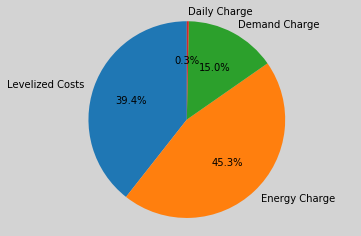

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 190, 260, 31, 6, 11, 0.7, 0.6499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29979.4


ERROR:ga_logger:total demand cost: 4479.192


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,090 kWh
At a cost of $ 0.0782 /kWh
Total Cost of the system: $ 29,979 per year


Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 135, 230, 56, 31, 16, 0.3, 0.6499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.118175268173218 sec


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29981.9


ERROR:ga_logger:total demand cost: 4453.746


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,432 kWh
At a cost of $ 0.0769 /kWh
Total Cost of the system: $ 29,982 per year


Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 260, 245, 46, 51, 16, 0.35, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.902559518814087 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29234.4


ERROR:ga_logger:total demand cost: 4484.235000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,384 kWh
At a cost of $ 0.0746 /kWh
Total Cost of the system: $ 29,234 per year


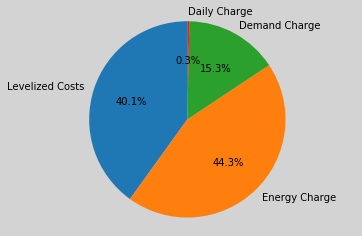

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 150, 155, 36, 31, 1, 0.35, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.235517501831055 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.500328063964844 sec


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29178.0


ERROR:ga_logger:total demand cost: 4465.575


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,785 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,178 per year


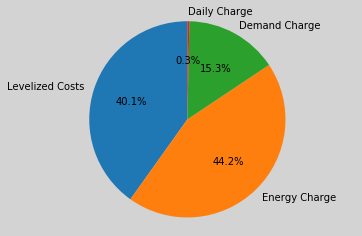

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 105, 195, 51, 41, 16, 0.6499999999999999, 0.44999999999999996, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29612.6


ERROR:ga_logger:total demand cost: 4458.674999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,475 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 29,613 per year


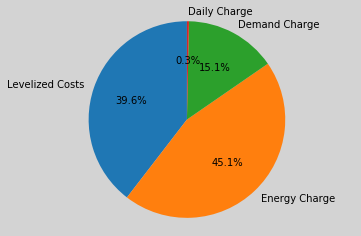

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 170, 185, 51, 56, 51, 0.5499999999999999, 0.2, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.430026531219482 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29622.6


ERROR:ga_logger:total demand cost: 4490.565


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,842 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 29,623 per year


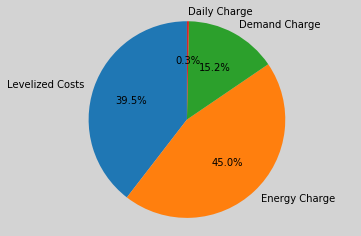

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 265, 255, 21, 26, 11, 0.49999999999999994, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.6259989738464355 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29306.5


ERROR:ga_logger:total demand cost: 4460.385


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,779 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 29,306 per year


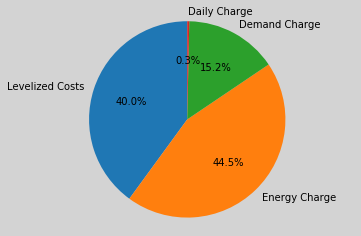

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 175, 215, 36, 6, 56, 0.35, 0.5499999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30108.6


ERROR:ga_logger:total demand cost: 4450.91


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,457 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 30,109 per year


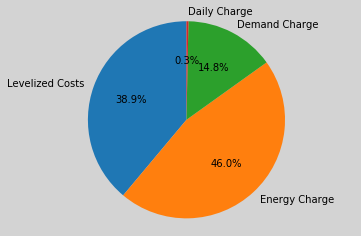

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 230, 175, 41, 36, 46, 0.39999999999999997, 0.49999999999999994, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.440979242324829 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.018913984298706 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29090.0


ERROR:ga_logger:total demand cost: 4478.659


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,346 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,090 per year


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
20
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      100
azi1      150
azi2      155
tilt0      36
tilt1      31
tilt2       1
gcr0     0.35
gcr1      0.3
gcr2      0.6
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29178.0


ERROR:ga_logger:total demand cost: 4465.575


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,785 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,178 per year


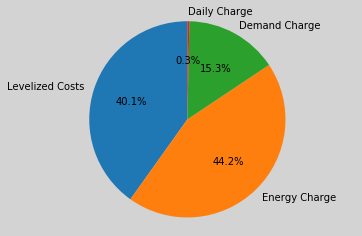

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[100, 150, 155, 36, 31, 1, 0.35, 0.3, 0.5999999999999999, 29178.0, 625.0, 0.0, 625.0, 0.0, 1, 'red', {'Levelized Costs': 11712.5327, 'Energy Charge': 12902.3278, 'Demand Charge': 4465.575, 'Daily Charge': 97.5645}, 130280.64065762, 169785.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      185
azi1       95
azi2      195
tilt0      31
tilt1      46
tilt2      26
gcr0      0.2
gcr1     0.55
gcr2      0.7
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28885.3


ERROR:ga_logger:total demand cost: 4463.697


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,550 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 28,885 per year


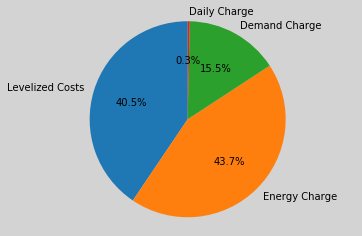

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[185, 95, 195, 31, 46, 26, 0.2, 0.5499999999999999, 0.7, 28885.3, 625.0, 625.0, 0.0, 0.0, 1, 'red', {'Levelized Costs': 11712.4872, 'Energy Charge': 12611.5513, 'Demand Charge': 4463.697, 'Daily Charge': 97.5645}, 133229.53615895897, 171550.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0       90
azi1      175
azi2      265
tilt0      46
tilt1      36
tilt2       1
gcr0     0.35
gcr1      0.3
gcr2     0.45
Name: 2, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 28935.2


ERROR:ga_logger:total demand cost: 4470.735


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,855 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 28,935 per year


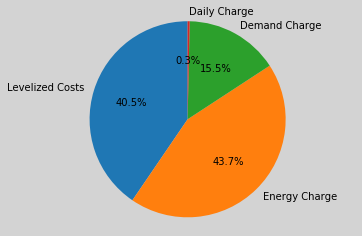

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[90, 175, 265, 46, 36, 1, 0.35, 0.3, 0.45, 28935.2, 625.0, 0.0, 625.0, 0.0, 1, 'red', {'Levelized Costs': 11712.473699999999, 'Energy Charge': 12654.426800000001, 'Demand Charge': 4470.735, 'Daily Charge': 97.5645}, 132794.73079270023, 170855.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      110
azi1      235
azi2      150
tilt0      31
tilt1       1
tilt2      26
gcr0      0.4
gcr1      0.2
gcr2     0.35
Name: 3, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29260.7


ERROR:ga_logger:total demand cost: 4462.004999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,317 kWh
At a cost of $ 0.0763 /kWh
Total Cost of the system: $ 29,261 per year


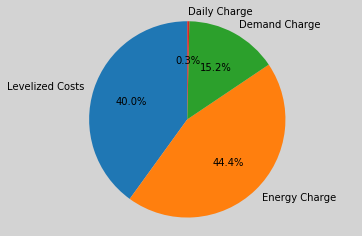

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[110, 235, 150, 31, 1, 26, 0.4, 0.2, 0.35, 29260.7, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.455199999999, 'Energy Charge': 12988.675300000003, 'Demand Charge': 4462.004999999999, 'Daily Charge': 97.5645}, 129404.88166057925, 170317.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0       95
azi1      180
azi2      165
tilt0      41
tilt1      36
tilt2      36
gcr0      0.9
gcr1     0.35
gcr2      0.8
Name: 4, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 28987.2


ERROR:ga_logger:total demand cost: 4472.204


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,771 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 28,987 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[95, 180, 165, 41, 36, 36, 0.8999999999999999, 0.35, 0.7999999999999998, 28987.2, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.488500000001, 'Energy Charge': 12704.943, 'Demand Charge': 4472.204, 'Daily Charge': 97.5645}, 132282.38745409972, 171771.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0     255
azi1     230
azi2     175
tilt0     41
tilt1     36
tilt2     46
gcr0     0.4
gcr1     0.5
gcr2     0.2
Name: 5, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29090.0


ERROR:ga_logger:total demand cost: 4478.659


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,346 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,090 per year


Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[255, 230, 175, 41, 36, 46, 0.4, 0.4999999999999999, 0.2, 29090.0, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.5193, 'Energy Charge': 12801.2572, 'Demand Charge': 4478.659, 'Daily Charge': 97.5645}, 131305.70199620008, 171346.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      170
azi1      160
azi2      235
tilt0      46
tilt1       6
tilt2      11
gcr0     0.25
gcr1      0.6
gcr2      0.9
Name: 6, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29156.0


ERROR:ga_logger:total demand cost: 4480.37


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,073 kWh
At a cost of $ 0.0752 /kWh
Total Cost of the system: $ 29,156 per year


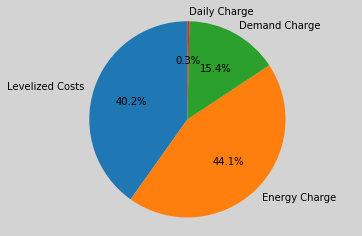

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[170, 160, 235, 46, 6, 11, 0.25, 0.5999999999999999, 0.8999999999999999, 29156.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.486399999998, 'Energy Charge': 12865.5791, 'Demand Charge': 4480.37, 'Daily Charge': 97.5645}, 130653.32840220015, 171073.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      175
azi1      160
azi2      120
tilt0      11
tilt1      21
tilt2      21
gcr0     0.75
gcr1     0.35
gcr2      0.7
Name: 7, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29238.3


ERROR:ga_logger:total demand cost: 4457.959000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,766 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,238 per year


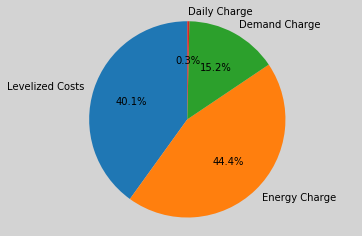

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[175, 160, 120, 11, 21, 21, 0.7499999999999998, 0.35, 0.7, 29238.3, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.489399999997, 'Energy Charge': 12970.287100000001, 'Demand Charge': 4457.959000000001, 'Daily Charge': 97.5645}, 129591.2321124994, 170766.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      255
azi1      155
azi2      220
tilt0      21
tilt1      31
tilt2      11
gcr0      0.7
gcr1     0.45
gcr2     0.25
Name: 8, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29283.6


ERROR:ga_logger:total demand cost: 4469.484


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,113 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,284 per year


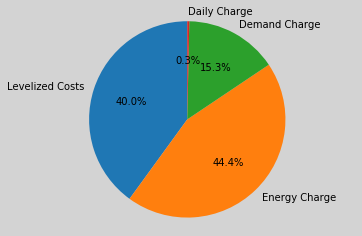

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[255, 155, 220, 21, 31, 11, 0.7, 0.45, 0.25, 29283.6, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.465799999996, 'Energy Charge': 13004.085700000001, 'Demand Charge': 4469.484, 'Daily Charge': 97.5645}, 129248.59644467013, 171113.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      260
azi1      185
azi2      255
tilt0      36
tilt1      41
tilt2       6
gcr0     0.35
gcr1     0.35
gcr2      0.3
Name: 9, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29063.5


ERROR:ga_logger:total demand cost: 4478.042


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,744 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 29,064 per year


Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[260, 185, 255, 36, 41, 6, 0.35, 0.35, 0.3, 29063.5, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.569999999996, 'Energy Charge': 12775.323500000002, 'Demand Charge': 4478.042, 'Daily Charge': 97.5645}, 131568.48540545983, 172744.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      155
azi1      105
azi2      180
tilt0       6
tilt1      51
tilt2      26
gcr0     0.35
gcr1      0.6
gcr2     0.45
Name: 10, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 45s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29101.8


ERROR:ga_logger:total demand cost: 4464.223


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,126 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,102 per year


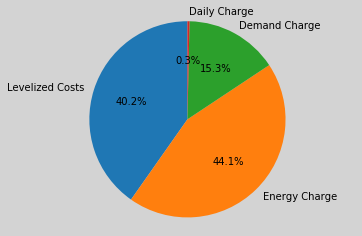

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[155, 105, 180, 6, 51, 26, 0.35, 0.5999999999999999, 0.45, 29101.8, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.4592, 'Energy Charge': 12827.5533, 'Demand Charge': 4464.223, 'Daily Charge': 97.5645}, 131038.97281610021, 172126.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      240
azi1      150
azi2      165
tilt0      41
tilt1      46
tilt2      26
gcr0      0.6
gcr1      0.4
gcr2     0.45
Name: 11, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29160.2


ERROR:ga_logger:total demand cost: 4464.168


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,118 kWh
At a cost of $ 0.0753 /kWh
Total Cost of the system: $ 29,160 per year


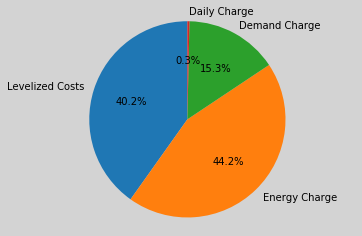

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[240, 150, 165, 41, 46, 26, 0.5999999999999999, 0.4, 0.45, 29160.2, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.466600000002, 'Energy Charge': 12886.0009, 'Demand Charge': 4464.168, 'Daily Charge': 97.5645}, 130446.0470794005, 171118.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      170
azi1      115
azi2      185
tilt0      36
tilt1       1
tilt2      51
gcr0     0.45
gcr1     0.25
gcr2     0.65
Name: 12, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29147.4


ERROR:ga_logger:total demand cost: 4475.444


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,662 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,147 per year


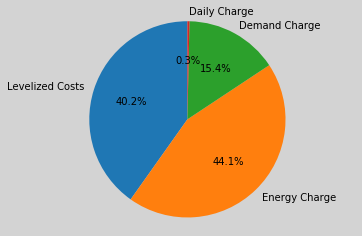

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[170, 115, 185, 36, 1, 51, 0.45, 0.25, 0.6499999999999999, 29147.4, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.513500000001, 'Energy Charge': 12861.878, 'Demand Charge': 4475.444, 'Daily Charge': 97.5645}, 130690.8410803, 171662.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0     185
azi1     170
azi2     160
tilt0     31
tilt1      1
tilt2     31
gcr0     0.5
gcr1     0.8
gcr2     0.7
Name: 13, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29106.9


ERROR:ga_logger:total demand cost: 4471.19


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,846 kWh
At a cost of $ 0.0742 /kWh
Total Cost of the system: $ 29,107 per year


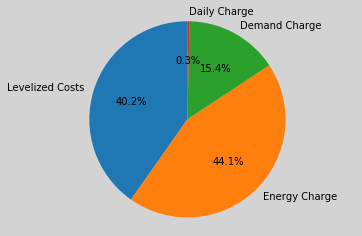

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
[[185, 170, 160, 31, 1, 31, 0.4999999999999999, 0.7999999999999998, 0.7, 29106.9, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.523400000002, 'Energy Charge': 12825.6221, 'Demand Charge': 4471.19, 'Daily Charge': 97.5645}, 131058.4435395509, 172846.0, 1250.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      145
azi1      220
azi2      175
tilt0      46
tilt1      16
tilt2      51
gcr0     0.25
gcr1     0.25
gcr2      0.5
Name: 14, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29557.2


ERROR:ga_logger:total demand cost: 4480.233


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,257 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 29,557 per year


Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[145, 220, 175, 46, 16, 51, 0.25, 0.25, 0.4999999999999999, 29557.2, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.458300000002, 'Energy Charge': 13266.944199999998, 'Demand Charge': 4480.233, 'Daily Charge': 97.5645}, 126582.64402540038, 171257.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      165
azi1      265
azi2      255
tilt0      21
tilt1      26
tilt2      11
gcr0      0.5
gcr1      0.3
gcr2     0.75
Name: 15, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29306.5


ERROR:ga_logger:total demand cost: 4460.385


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,779 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 29,306 per year


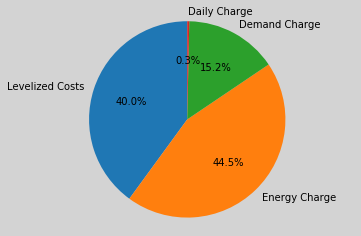

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
[[165, 265, 255, 21, 26, 11, 0.4999999999999999, 0.3, 0.7499999999999998, 29306.5, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.450599999998, 'Energy Charge': 13036.099900000001, 'Demand Charge': 4460.385, 'Daily Charge': 97.5645}, 128923.93535009971, 171779.0, 1250.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      190
azi1      200
azi2      175
tilt0      31
tilt1       6
tilt2      41
gcr0     0.75
gcr1     0.35
gcr2      0.4
Name: 16, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29161.4


ERROR:ga_logger:total demand cost: 4479.816


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,222 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,161 per year


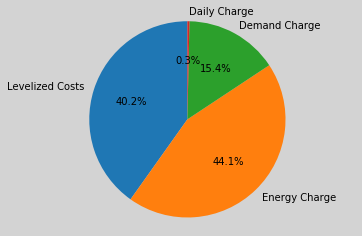

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
[[190, 200, 175, 31, 6, 41, 0.7499999999999998, 0.35, 0.4, 29161.4, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.511500000004, 'Energy Charge': 12871.507999999998, 'Demand Charge': 4479.816, 'Daily Charge': 97.5645}, 130593.18717389993, 172222.0, 1562.5]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      190
azi1      235
azi2      155
tilt0       6
tilt1      21
tilt2      16
gcr0     0.35
gcr1     0.85
gcr2      0.2
Name: 17, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  97s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29449.7


ERROR:ga_logger:total demand cost: 4453.57


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,384 kWh
At a cost of $ 0.0769 /kWh
Total Cost of the system: $ 29,450 per year


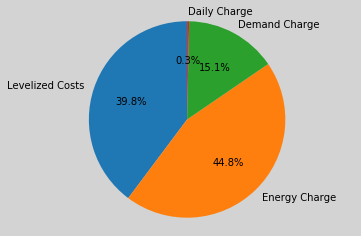

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[190, 235, 155, 6, 21, 16, 0.35, 0.8499999999999999, 0.2, 29449.7, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.495400000002, 'Energy Charge': 13186.070099999999, 'Demand Charge': 4453.57, 'Daily Charge': 97.5645}, 127402.81009459961, 171384.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      155
azi1      235
azi2      240
tilt0      21
tilt1      16
tilt2       1
gcr0      0.5
gcr1      0.9
gcr2     0.45
Name: 18, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29409.1


ERROR:ga_logger:total demand cost: 4460.357


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,083 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 29,409 per year


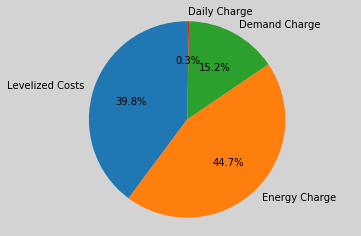

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
[[155, 235, 240, 21, 16, 1, 0.4999999999999999, 0.8999999999999999, 0.45, 29409.1, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.5122, 'Energy Charge': 13138.666299999999, 'Demand Charge': 4460.357, 'Daily Charge': 97.5645}, 127883.59232510018, 172083.0, 1250.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      190
azi1      140
azi2      140
tilt0      26
tilt1      41
tilt2      41
gcr0      0.5
gcr1      0.7
gcr2     0.85
Name: 19, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29180.1


ERROR:ga_logger:total demand cost: 4465.512000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,161 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,180 per year


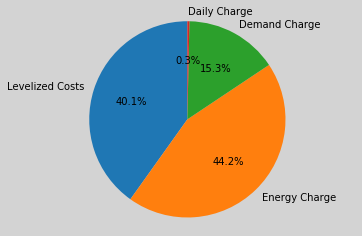

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
[[190, 140, 140, 26, 41, 41, 0.4999999999999999, 0.7, 0.8499999999999999, 29180.1, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.5149, 'Energy Charge': 12904.508599999997, 'Demand Charge': 4465.512000000001, 'Daily Charge': 97.5645}, 130258.30270055738, 173161.0, 1250.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)